<a href="https://colab.research.google.com/github/nikitos-net/Machine-learning-methods-for-automatic-recognition-of-fake-faces./blob/main/nn_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import VGG16

from huggingface_hub import login
from datasets import load_dataset
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from huggingface_hub import hf_hub_download, list_repo_files
import os
import tarfile

repo_id = "xingjunm/WildDeepfake"
fake_dir = "deepfake_in_the_wild/fake_test"
real_dir = "deepfake_in_the_wild/real_test"
local_dir = "downloaded_data"
fake_images_folder = "extracted_fake_images"
real_images_folder = "extracted_real_images"

os.makedirs(local_dir, exist_ok=True)
os.makedirs(fake_images_folder, exist_ok=True)
os.makedirs(real_images_folder, exist_ok=True)

files = list_repo_files(repo_id, repo_type="dataset")

for file_path in files:
    target_folder = None
    if file_path.startswith(fake_dir):
        target_folder = fake_dir
        output_folder = fake_images_folder
    elif file_path.startswith(real_dir):
        target_folder = real_dir
        output_folder = real_images_folder

    if target_folder:
        local_file_path = os.path.join(local_dir, file_path[len(target_folder) + 1:])
        try:
            print(f"Скачиваем {file_path}...")
            download_path = hf_hub_download(repo_id, filename=file_path, repo_type="dataset", local_dir=local_dir)
            file_size = os.path.getsize(download_path)
            print(f"  Файл скачан, размер: {file_size} байт")

            if file_path.endswith(".tar.gz"):
                print(f"  Распаковываем {file_path} как tar (без gzip)...")
                try:
                    with tarfile.open(download_path, 'r') as tar_ref:
                        for member in tar_ref.getmembers():
                            if not member.isdir() and any(member.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
                                try:
                                    image_file = tar_ref.extractfile(member)
                                    if image_file:
                                        image_data = image_file.read()
                                        local_image_path = os.path.join(output_folder, os.path.basename(member.name))
                                        with open(local_image_path, "wb") as f:
                                            f.write(image_data)
                                        #print(f"    Извлечено изображение: {member.name}")
                                except Exception as e:
                                    print(f"    Ошибка при извлечении изображения {member.name}: {e}")
                except Exception as e:
                    print(f"  Ошибка при распаковке архива {file_path}: {e}")
            else:
                print(f"  Файл {file_path} не является архивом tar.gz, пропущен")

            print(f"  Файл {file_path} обработан.")

        except Exception as e:
            print(f"Ошибка при скачивании файла {file_path}: {e}")

print("Загрузка и распаковка завершены.")

In [ ]:
!rm -r /content/downloaded_data/deepfake_in_the_wild/fake_test/*.gz /content/downloaded_data/deepfake_in_the_wild/real_test/*.gz

In [ ]:
def create_mesonet4():
    input_tensor = Input(shape=(256, 256, 3))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((4, 4))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [ ]:
def create_vgg16():
    input_tensor = Input(shape=(224, 224, 3))

    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)


    x = Flatten()(x)
    x = Dense(units=4096, activation="relu")(x)
    x = Dense(units=4096, activation="relu")(x)

    output_tensor = Dense(2, activation="softmax")(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

In [ ]:
def softmax_to_sigmoid(softmax_output):
    """Преобразует softmax выход в sigmoid используя разницу логитов."""
    if len(softmax_output) == 2:
        # Вычисляем разницу логитов
        x = softmax_output[1] - softmax_output[0]
        #применяем сигмоиду
        sigmoid_output = 1 / (1 + tf.exp(-x))
        return sigmoid_output.numpy() # Возвращаем значение как numpy
    else:
        return None

In [ ]:
def load_model(model_path):
    try:
        model = models.load_model(model_path)
        print(f"Модель успешно загружена из {model_path}")
        return model
    except Exception as e:
        print(f"Ошибка при загрузке модели из {model_path}: {e}")
        return None

In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Ошибка при предобработке изображения {image_path}: {e}")
        return None

In [ ]:
def predict_deepfake(preprocessed_image, model):
    if preprocessed_image is None:
        return None # Предобработка не удалась

    if model:
        prediction = model.predict(preprocessed_image)[0] # Получаем весь вектор предсказаний
        if len(prediction) == 1: # sigmoid
            print('sig')
            return float(prediction[0]) # Преобразуем в float
        elif len(prediction) == 2: # softmax
            print('soft')
            return float(softmax_to_sigmoid(prediction)) # Преобразуем в float
        else:
            return None
    else:
        return None

In [ ]:
'''
def evaluate_model(model, image_dir, num_images=50, batch_size=32, target_size=(256, 256), is_resnet=False):
    y_true = []
    y_pred = []
    y_pred_probs = []

    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.jpeg")) + glob.glob(os.path.join(image_dir, "*.png"))
    image_paths = image_paths[:num_images]

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_labels = []

        for image_path in batch_paths:
            try:
                if is_resnet:
                    img = preprocess_image(image_path, target_size=(224, 224))
                else:
                    img = preprocess_image(image_path, target_size=target_size)

                if img is not None:
                    batch_images.append(img)
                    label = 1 if "fake" in image_path.lower() else 0
                    batch_labels.append(label)
            except Exception as e:
                print(f"Ошибка при обработке изображения {image_path}: {e}")

        if batch_images:
            batch_images = np.vstack(batch_images)
            try:
                batch_predictions = model.predict(batch_images)
                y_pred_probs.extend(batch_predictions[:,0])
                y_pred.extend([round(p) for p in batch_predictions[:,0]])
                y_true.extend(batch_labels)
            except Exception as e:
                print(f"Ошибка при предсказании для пакета: {e}")


    return y_true, y_pred, y_pred_probs
'''

In [ ]:
def evaluate_model(model, image_dir, num_images=50, batch_size=32, target_size=(256, 256), is_resnet=False):
    y_true = []
    y_pred_probs = []

    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.jpeg")) + glob.glob(os.path.join(image_dir, "*.png"))
    image_paths = image_paths[:num_images]

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_labels = []

        for image_path in batch_paths:
            try:
                if is_resnet:
                    img = preprocess_image(image_path, target_size=(224, 224))
                else:
                    img = preprocess_image(image_path, target_size=target_size)

                if img is not None:
                    batch_images.append(img)
                    label = 1 if "fake" in image_path.lower() else 0
                    batch_labels.append(label)
            except Exception as e:
                print(f"Ошибка при обработке изображения {image_path}: {e}")
        if batch_images:
            batch_images = np.vstack(batch_images)
            try:
                print("f")
                batch_predictions = model.predict(batch_images)
                y_pred_probs.extend(batch_predictions[:,0])
                y_true.extend(batch_labels)
            except Exception as e:
                print(f"Ошибка при предсказании для пакета: {e}")

    return y_true, y_pred_probs

In [ ]:
mesonet4_model = create_mesonet4()
try:
    mesonet4_model.load_weights('/content/Meso4.h5')
    print("Веса успешно загружены из /content/Meso4.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    mesonet4_model = None

mesonet4_model.summary()

Веса успешно загружены из /content/Meso4.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
resnet50_model_1 = load_model('/content/Res_01.keras')
if resnet50_model_1:
    resnet50_model_1.summary()

Модель успешно загружена из /content/Res_01.keras


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051,013 (271.04 MB)

 Trainable params: 23,665,921 (90.28 MB)

 Non-trainable params: 53,248 (208.00 KB)

 Optimizer params: 47,331,844 (180.56 MB)

In [ ]:
resnet50_model_2 = load_model('/content/Res_02.keras')
if resnet50_model_2:
    resnet50_model_2.summary()

Модель успешно загружена из /content/Res_02.keras


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,115,333 (282.73 MB)

 Trainable params: 24,687,233 (94.17 MB)

 Non-trainable params: 53,632 (209.50 KB)

 Optimizer params: 49,374,468 (188.35 MB)

In [ ]:
inceptionv3_model = load_model('/content/ICV3.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/ICV3.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)

In [ ]:
xception_model = load_model('/content/Xception.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/Xception.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)


Оценка /content/Xception:
Поддельные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step


  3%|▎         | 1/32 [01:22<42:39, 82.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step


  6%|▋         | 2/32 [02:45<41:30, 83.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step


  9%|▉         | 3/32 [03:27<30:56, 64.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step


 12%|█▎        | 4/32 [04:50<33:19, 71.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 11s/step


 16%|█▌        | 5/32 [05:32<27:22, 60.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 19%|█▉        | 6/32 [06:11<23:11, 53.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 22%|██▏       | 7/32 [06:52<20:39, 49.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 25%|██▌       | 8/32 [07:33<18:37, 46.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 28%|██▊       | 9/32 [08:14<17:16, 45.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step


 31%|███▏      | 10/32 [09:37<20:48, 56.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 34%|███▍      | 11/32 [10:17<18:01, 51.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 38%|███▊      | 12/32 [10:57<15:57, 47.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 41%|████      | 13/32 [11:36<14:20, 45.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step


 44%|████▍     | 14/32 [12:19<13:23, 44.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 47%|████▋     | 15/32 [12:58<12:10, 42.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step


 50%|█████     | 16/32 [13:38<11:14, 42.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 53%|█████▎    | 17/32 [14:18<10:21, 41.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 56%|█████▋    | 18/32 [15:00<09:41, 41.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 12s/step


 59%|█████▉    | 19/32 [16:22<11:39, 53.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step


 62%|██████▎   | 20/32 [17:07<10:11, 50.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 66%|██████▌   | 21/32 [17:48<08:49, 48.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 69%|██████▉   | 22/32 [18:27<07:33, 45.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step


 72%|███████▏  | 23/32 [19:50<08:28, 56.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 75%|███████▌  | 24/32 [20:29<06:49, 51.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 78%|███████▊  | 25/32 [21:08<05:33, 47.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 81%|████████▏ | 26/32 [21:50<04:35, 45.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step


 84%|████████▍ | 27/32 [23:12<04:44, 56.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 88%|████████▊ | 28/32 [23:54<03:29, 52.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 91%|█████████ | 29/32 [24:35<02:27, 49.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 94%|█████████▍| 30/32 [25:15<01:32, 46.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step


 97%|█████████▋| 31/32 [25:58<00:45, 45.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|██████████| 32/32 [26:19<00:00, 49.35s/it]


Реальные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


  3%|▎         | 1/32 [00:41<21:26, 41.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


  6%|▋         | 2/32 [01:23<20:47, 41.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


  9%|▉         | 3/32 [02:04<20:04, 41.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 12%|█▎        | 4/32 [02:46<19:22, 41.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 16%|█▌        | 5/32 [03:27<18:44, 41.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 19%|█▉        | 6/32 [04:06<17:34, 40.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 22%|██▏       | 7/32 [04:47<17:00, 40.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 25%|██▌       | 8/32 [05:26<16:05, 40.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 28%|██▊       | 9/32 [06:08<15:34, 40.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step


 31%|███▏      | 10/32 [07:31<19:39, 53.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 34%|███▍      | 11/32 [08:09<17:10, 49.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 38%|███▊      | 12/32 [08:51<15:35, 46.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 41%|████      | 13/32 [09:32<14:18, 45.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step


 44%|████▍     | 14/32 [10:55<16:57, 56.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 47%|████▋     | 15/32 [11:37<14:45, 52.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 50%|█████     | 16/32 [12:15<12:48, 48.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 53%|█████▎    | 17/32 [12:54<11:19, 45.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step


 56%|█████▋    | 18/32 [14:17<13:10, 56.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 59%|█████▉    | 19/32 [14:56<11:05, 51.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 62%|██████▎   | 20/32 [15:37<09:39, 48.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 66%|██████▌   | 21/32 [16:18<08:24, 45.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step


 69%|██████▉   | 22/32 [17:40<09:29, 56.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step


 72%|███████▏  | 23/32 [18:22<07:50, 52.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step


 75%|███████▌  | 24/32 [19:01<06:26, 48.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 78%|███████▊  | 25/32 [19:40<05:19, 45.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step


 81%|████████▏ | 26/32 [20:27<04:35, 45.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 84%|████████▍ | 27/32 [21:06<03:38, 43.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step


 88%|████████▊ | 28/32 [21:47<02:52, 43.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


 91%|█████████ | 29/32 [22:26<02:05, 41.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step


 94%|█████████▍| 30/32 [23:08<01:23, 41.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step


 97%|█████████▋| 31/32 [24:31<00:54, 54.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|██████████| 32/32 [24:42<00:00, 46.34s/it]


  ROC AUC: 0.5496
Оценка Mesonet4:
Поддельные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step


  3%|▎         | 1/32 [00:03<01:34,  3.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step


  6%|▋         | 2/32 [00:06<01:31,  3.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step


  9%|▉         | 3/32 [00:11<02:04,  4.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


 12%|█▎        | 4/32 [00:15<01:50,  3.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step


 16%|█▌        | 5/32 [00:18<01:37,  3.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step


 19%|█▉        | 6/32 [00:21<01:29,  3.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step


 22%|██▏       | 7/32 [00:24<01:23,  3.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 881ms/step


 25%|██▌       | 8/32 [00:30<01:39,  4.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step


 28%|██▊       | 9/32 [00:33<01:27,  3.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step


 31%|███▏      | 10/32 [00:35<01:14,  3.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step


 34%|███▍      | 11/32 [00:39<01:09,  3.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step


 38%|███▊      | 12/32 [00:42<01:06,  3.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step


 41%|████      | 13/32 [00:48<01:18,  4.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 44%|████▍     | 14/32 [00:50<01:04,  3.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 47%|████▋     | 15/32 [00:53<00:54,  3.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


 50%|█████     | 16/32 [00:56<00:50,  3.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/step


 53%|█████▎    | 17/32 [00:59<00:47,  3.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 876ms/step


 56%|█████▋    | 18/32 [01:05<00:55,  3.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step


 59%|█████▉    | 19/32 [01:08<00:48,  3.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step


 62%|██████▎   | 20/32 [01:11<00:42,  3.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step


 66%|██████▌   | 21/32 [01:14<00:37,  3.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step


 69%|██████▉   | 22/32 [01:20<00:41,  4.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step


 72%|███████▏  | 23/32 [01:23<00:35,  3.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step


 75%|███████▌  | 24/32 [01:25<00:27,  3.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step


 78%|███████▊  | 25/32 [01:29<00:23,  3.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step


 81%|████████▏ | 26/32 [01:32<00:19,  3.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step


 84%|████████▍ | 27/32 [01:35<00:16,  3.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 88%|████████▊ | 28/32 [01:41<00:16,  4.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step


 91%|█████████ | 29/32 [01:44<00:10,  3.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step


 94%|█████████▍| 30/32 [01:47<00:06,  3.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 867ms/step


 97%|█████████▋| 31/32 [01:52<00:04,  4.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


100%|██████████| 32/32 [01:54<00:00,  3.58s/it]


Реальные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 877ms/step


  3%|▎         | 1/32 [00:04<02:15,  4.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step


  6%|▋         | 2/32 [00:07<01:51,  3.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


  9%|▉         | 3/32 [00:10<01:30,  3.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 12%|█▎        | 4/32 [00:13<01:26,  3.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step


 16%|█▌        | 5/32 [00:16<01:24,  3.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step


 19%|█▉        | 6/32 [00:22<01:45,  4.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 22%|██▏       | 7/32 [00:24<01:31,  3.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step


 25%|██▌       | 8/32 [00:28<01:23,  3.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


 28%|██▊       | 9/32 [00:31<01:18,  3.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step


 31%|███▏      | 10/32 [00:33<01:09,  3.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step


 34%|███▍      | 11/32 [00:37<01:11,  3.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step


 38%|███▊      | 12/32 [00:41<01:11,  3.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step


 41%|████      | 13/32 [00:44<01:01,  3.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 44%|████▍     | 14/32 [00:46<00:53,  2.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step


 47%|████▋     | 15/32 [00:49<00:50,  2.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step


 50%|█████     | 16/32 [00:52<00:48,  3.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step


 53%|█████▎    | 17/32 [00:56<00:50,  3.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step


 56%|█████▋    | 18/32 [01:00<00:47,  3.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 59%|█████▉    | 19/32 [01:02<00:39,  3.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step


 62%|██████▎   | 20/32 [01:05<00:36,  3.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 66%|██████▌   | 21/32 [01:08<00:31,  2.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step


 69%|██████▉   | 22/32 [01:11<00:29,  2.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step


 72%|███████▏  | 23/32 [01:17<00:34,  3.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step


 75%|███████▌  | 24/32 [01:20<00:28,  3.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step


 78%|███████▊  | 25/32 [01:23<00:24,  3.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step


 81%|████████▏ | 26/32 [01:25<00:18,  3.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 84%|████████▍ | 27/32 [01:28<00:15,  3.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 844ms/step


 88%|████████▊ | 28/32 [01:34<00:15,  3.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step


 91%|█████████ | 29/32 [01:37<00:11,  3.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


 94%|█████████▍| 30/32 [01:40<00:06,  3.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step


 97%|█████████▋| 31/32 [01:43<00:03,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


100%|██████████| 32/32 [01:43<00:00,  3.25s/it]


  ROC AUC: 0.3563

Оценка ResNet50_1:
Поддельные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step


  3%|▎         | 1/32 [00:41<21:23, 41.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


  6%|▋         | 2/32 [01:22<20:45, 41.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step


  9%|▉         | 3/32 [02:04<20:03, 41.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 12%|█▎        | 4/32 [02:45<19:21, 41.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 16%|█▌        | 5/32 [03:10<15:51, 35.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 19%|█▉        | 6/32 [03:34<13:37, 31.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 22%|██▏       | 7/32 [04:01<12:31, 30.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 25%|██▌       | 8/32 [04:42<13:27, 33.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step


 28%|██▊       | 9/32 [05:24<13:50, 36.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 31%|███▏      | 10/32 [06:05<13:51, 37.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 34%|███▍      | 11/32 [06:47<13:36, 38.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 38%|███▊      | 12/32 [07:12<11:33, 34.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 41%|████      | 13/32 [07:36<09:59, 31.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 44%|████▍     | 14/32 [08:04<09:07, 30.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


 47%|████▋     | 15/32 [08:30<08:17, 29.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 50%|█████     | 16/32 [09:12<08:47, 32.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 53%|█████▎    | 17/32 [09:54<08:52, 35.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 56%|█████▋    | 18/32 [10:35<08:42, 37.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 59%|█████▉    | 19/32 [11:16<08:21, 38.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step


 62%|██████▎   | 20/32 [11:58<07:52, 39.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 66%|██████▌   | 21/32 [12:25<06:33, 35.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 69%|██████▉   | 22/32 [12:49<05:22, 32.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 72%|███████▏  | 23/32 [13:31<05:14, 34.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 75%|███████▌  | 24/32 [13:55<04:14, 31.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 78%|███████▊  | 25/32 [14:19<03:25, 29.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 81%|████████▏ | 26/32 [15:00<03:18, 33.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 84%|████████▍ | 27/32 [15:42<02:57, 35.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 88%|████████▊ | 28/32 [16:10<02:12, 33.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 91%|█████████ | 29/32 [16:33<01:31, 30.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 94%|█████████▍| 30/32 [16:58<00:57, 28.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 97%|█████████▋| 31/32 [17:24<00:27, 27.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


100%|██████████| 32/32 [17:29<00:00, 32.81s/it]


Реальные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


  3%|▎         | 1/32 [00:41<21:24, 41.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


  6%|▋         | 2/32 [01:09<16:44, 33.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


  9%|▉         | 3/32 [01:50<17:55, 37.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 12%|█▎        | 4/32 [02:32<18:09, 38.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 16%|█▌        | 5/32 [02:57<15:12, 33.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 19%|█▉        | 6/32 [03:38<15:47, 36.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 22%|██▏       | 7/32 [04:03<13:31, 32.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step


 25%|██▌       | 8/32 [04:44<14:09, 35.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


 28%|██▊       | 9/32 [05:11<12:34, 32.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 31%|███▏      | 10/32 [05:53<13:00, 35.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 34%|███▍      | 11/32 [06:34<13:04, 37.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 38%|███▊      | 12/32 [07:16<12:52, 38.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step


 41%|████      | 13/32 [07:58<12:31, 39.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 44%|████▍     | 14/32 [08:39<12:03, 40.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 47%|████▋     | 15/32 [09:21<11:29, 40.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 50%|█████     | 16/32 [09:45<09:32, 35.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 53%|█████▎    | 17/32 [10:09<08:03, 32.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step


 56%|█████▋    | 18/32 [10:38<07:16, 31.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 59%|█████▉    | 19/32 [11:04<06:24, 29.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 62%|██████▎   | 20/32 [11:28<05:33, 27.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 66%|██████▌   | 21/32 [12:09<05:50, 31.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 69%|██████▉   | 22/32 [12:33<04:55, 29.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 72%|███████▏  | 23/32 [13:15<04:58, 33.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 75%|███████▌  | 24/32 [13:39<04:04, 30.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 78%|███████▊  | 25/32 [14:06<03:27, 29.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 81%|████████▏ | 26/32 [14:48<03:19, 33.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 84%|████████▍ | 27/32 [15:30<02:58, 35.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 88%|████████▊ | 28/32 [16:11<02:29, 37.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 91%|█████████ | 29/32 [16:35<01:40, 33.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


 94%|█████████▍| 30/32 [17:17<01:11, 35.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


 97%|█████████▋| 31/32 [17:44<00:33, 33.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


100%|██████████| 32/32 [17:50<00:00, 33.44s/it]


  ROC AUC: 0.5023

Оценка InceptionV3:
Поддельные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


  3%|▎         | 1/32 [00:41<21:23, 41.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


  6%|▋         | 2/32 [01:22<20:42, 41.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


  9%|▉         | 3/32 [02:04<20:02, 41.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


 12%|█▎        | 4/32 [02:29<16:19, 34.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 16%|█▌        | 5/32 [02:50<13:30, 30.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 19%|█▉        | 6/32 [03:32<14:41, 33.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 22%|██▏       | 7/32 [04:13<15:08, 36.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 25%|██▌       | 8/32 [04:54<15:12, 38.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 28%|██▊       | 9/32 [05:36<14:58, 39.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 31%|███▏      | 10/32 [06:00<12:35, 34.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 34%|███▍      | 11/32 [06:41<12:48, 36.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 38%|███▊      | 12/32 [07:23<12:41, 38.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 41%|████      | 13/32 [07:44<10:26, 32.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 44%|████▍     | 14/32 [08:25<10:39, 35.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 47%|████▋     | 15/32 [09:07<10:35, 37.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 50%|█████     | 16/32 [09:28<08:40, 32.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 53%|█████▎    | 17/32 [10:10<08:49, 35.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 56%|█████▋    | 18/32 [10:52<08:40, 37.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 59%|█████▉    | 19/32 [11:15<07:10, 33.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


 62%|██████▎   | 20/32 [11:38<05:58, 29.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 66%|██████▌   | 21/32 [12:19<06:07, 33.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step


 69%|██████▉   | 22/32 [12:48<05:18, 31.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


 72%|███████▏  | 23/32 [13:29<05:12, 34.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 75%|███████▌  | 24/32 [13:51<04:06, 30.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


 78%|███████▊  | 25/32 [14:13<03:16, 28.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 81%|████████▏ | 26/32 [14:37<02:41, 26.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 84%|████████▍ | 27/32 [14:58<02:06, 25.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step


 88%|████████▊ | 28/32 [15:19<01:35, 23.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


 91%|█████████ | 29/32 [16:00<01:27, 29.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


 94%|█████████▍| 30/32 [16:27<00:57, 28.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 97%|█████████▋| 31/32 [16:49<00:26, 26.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


100%|██████████| 32/32 [16:54<00:00, 31.72s/it]


Реальные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


  3%|▎         | 1/32 [00:23<12:05, 23.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


  6%|▋         | 2/32 [01:04<17:00, 34.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


  9%|▉         | 3/32 [01:28<14:03, 29.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


 12%|█▎        | 4/32 [01:52<12:42, 27.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 16%|█▌        | 5/32 [02:34<14:36, 32.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


 19%|█▉        | 6/32 [03:15<15:24, 35.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 22%|██▏       | 7/32 [03:39<13:13, 31.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 25%|██▌       | 8/32 [04:21<13:56, 34.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


 28%|██▊       | 9/32 [04:43<11:54, 31.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


 31%|███▏      | 10/32 [05:25<12:35, 34.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 34%|███▍      | 11/32 [05:46<10:37, 30.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 38%|███▊      | 12/32 [06:28<11:14, 33.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 41%|████      | 13/32 [06:49<09:29, 29.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 44%|████▍     | 14/32 [07:11<08:13, 27.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 47%|████▋     | 15/32 [07:52<08:57, 31.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


 50%|█████     | 16/32 [08:34<09:13, 34.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


 53%|█████▎    | 17/32 [08:56<07:44, 30.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


 56%|█████▋    | 18/32 [09:20<06:41, 28.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 59%|█████▉    | 19/32 [09:41<05:44, 26.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 62%|██████▎   | 20/32 [10:22<06:11, 30.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step


 66%|██████▌   | 21/32 [10:45<05:14, 28.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step


 69%|██████▉   | 22/32 [11:10<04:35, 27.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


 72%|███████▏  | 23/32 [11:52<04:45, 31.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


 75%|███████▌  | 24/32 [12:15<03:53, 29.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 78%|███████▊  | 25/32 [12:37<03:08, 26.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 81%|████████▏ | 26/32 [12:58<02:31, 25.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 84%|████████▍ | 27/32 [13:40<02:30, 30.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step


 88%|████████▊ | 28/32 [14:01<01:49, 27.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step


 91%|█████████ | 29/32 [14:26<01:20, 26.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


 94%|█████████▍| 30/32 [14:54<00:54, 27.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


 97%|█████████▋| 31/32 [15:35<00:31, 31.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


100%|██████████| 32/32 [15:41<00:00, 29.42s/it]

  ROC AUC: 0.4912


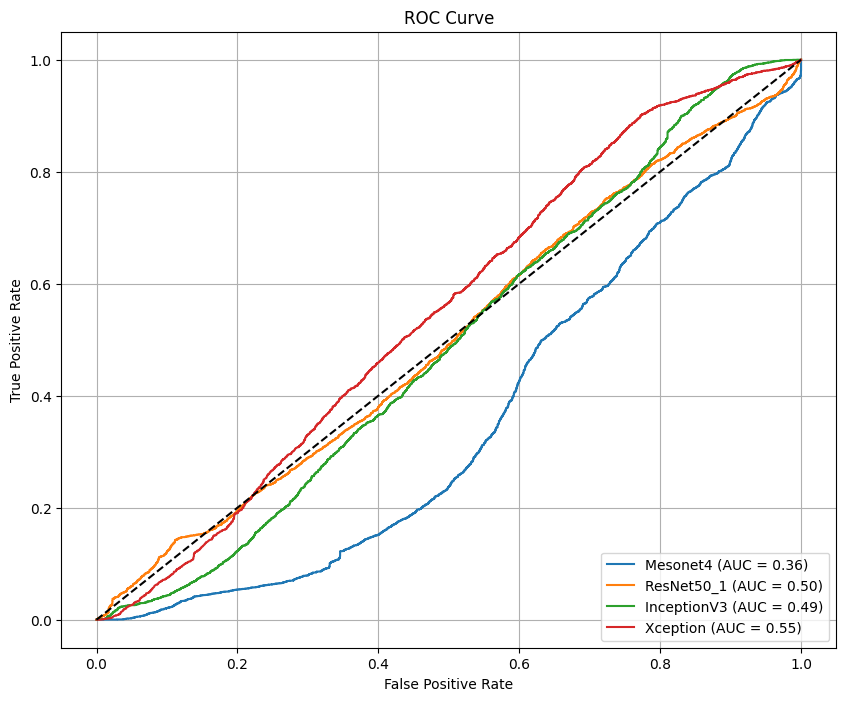

In [ ]:
if __name__ == '__main__':
    fake_dir = "extracted_fake_images"
    real_dir = "extracted_real_images"

    print("\nОценка /content/Xception:")
    print("Поддельные изображения:")
    y_true_xception, y_pred_probs_xception = evaluate_model(xception_model, fake_dir, num_images=4000, batch_size=128)
    print("Реальные изображения:")
    y_true_xception_real, y_pred_probs_xception_real = evaluate_model(xception_model, real_dir, num_images=4000, batch_size=128)
    y_true_xception.extend(y_true_xception_real)
    y_pred_probs_xception.extend(y_pred_probs_xception_real)

    roc_auc_xception = roc_auc_score(y_true_xception, y_pred_probs_xception)
    print(f"  ROC AUC: {roc_auc_xception:.4f}")


    print("Оценка Mesonet4:")
    print("Поддельные изображения:")
    y_true_meso, y_pred_probs_meso = evaluate_model(mesonet4_model, fake_dir, num_images=4000, batch_size=128)
    print("Реальные изображения:")
    y_true_meso_real, y_pred_probs_meso_real = evaluate_model(mesonet4_model, real_dir, num_images=4000, batch_size=128)
    y_true_meso.extend(y_true_meso_real)
    y_pred_probs_meso.extend(y_pred_probs_meso_real)

    roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
    print(f"  ROC AUC: {roc_auc_meso:.4f}")


    print("\nОценка ResNet50_1:")
    print("Поддельные изображения:")
    y_true_resnet1, y_pred_probs_resnet1 = evaluate_model(resnet50_model_1, fake_dir, is_resnet=True, num_images=4000, batch_size=128)
    print("Реальные изображения:")
    y_true_resnet1_real, y_pred_probs_resnet1_real = evaluate_model(resnet50_model_1, real_dir, is_resnet=True, num_images=4000, batch_size=128)
    y_true_resnet1.extend(y_true_resnet1_real)
    y_pred_probs_resnet1.extend(y_pred_probs_resnet1_real)

    roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
    print(f"  ROC AUC: {roc_auc_resnet1:.4f}")

    print("\nОценка InceptionV3:")
    print("Поддельные изображения:")
    y_true_inception, y_pred_probs_inception = evaluate_model(inceptionv3_model, fake_dir, is_resnet=True, num_images=4000, batch_size=128)
    print("Реальные изображения:")
    y_true_inception_real, y_pred_probs_inception_real = evaluate_model(inceptionv3_model, real_dir, is_resnet=True, num_images=4000, batch_size=128)
    y_true_inception.extend(y_true_inception_real)
    y_pred_probs_inception.extend(y_pred_probs_inception_real)

    roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
    print(f"  ROC AUC: {roc_auc_inception:.4f}")


    fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

    fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

    #fpr_resnet2, tpr_resnet2, thresholds_resnet2 = roc_curve(y_true_resnet2, y_pred_probs_resnet2)

    fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

    fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_meso, tpr_meso, label=f'Mesonet4 (AUC = {roc_auc_meso:.2f})')
    plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50_1 (AUC = {roc_auc_resnet1:.2f})')
    plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
    #plt.plot(fpr_resnet2, tpr_resnet2, label=f'ResNet50_2 (AUC = {roc_auc_resnet2:.2f})')
    plt.plot(fpr_xception, tpr_xception, label=f'Xception (AUC = {roc_auc_xception:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
vgg16_model = create_vgg16()
try:
    vgg16_model.load_weights('/content/VGG16.h5')
    print("Веса успешно загружены из /content/VGG16.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    vgg16_model = None

vgg16_model.summary()


Веса успешно загружены из /content/VGG16.h5


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 7, 7, 512)           │           2,0

 Total params: 134,271,042 (512.20 MB)

 Trainable params: 134,269,890 (512.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
    print("\nОценка VGG16:")
    print("Поддельные изображения:")
    y_true_vgg16, y_pred_probs_vgg16 = evaluate_model(vgg16_model, fake_dir, is_resnet=True, num_images=4000, batch_size=128)
    print("Реальные изображения:")
    y_true_vgg16_real, y_pred_probs_vgg16_real = evaluate_model(vgg16_model, real_dir, is_resnet=True, num_images=4000, batch_size=128)
    y_true_vgg16.extend(y_true_vgg16_real)
    y_pred_probs_vgg16.extend(y_pred_probs_vgg16_real)
    softmax_to_sigmoid(y_pred_probs_vgg16)

    roc_auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_probs_vgg16)
    print(f"  ROC AUC: {roc_auc_vgg16:.4f}")


Оценка VGG16:
Поддельные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


  3%|▎         | 1/32 [01:17<40:10, 77.75s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 21s/step


  6%|▋         | 2/32 [02:44<41:27, 82.93s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


  9%|▉         | 3/32 [04:06<39:58, 82.71s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 12%|█▎        | 4/32 [05:24<37:41, 80.77s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 16%|█▌        | 5/32 [06:42<35:52, 79.73s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 19%|█▉        | 6/32 [08:04<34:56, 80.62s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 22%|██▏       | 7/32 [09:27<33:49, 81.18s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 20s/step


 25%|██▌       | 8/32 [10:49<32:37, 81.55s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 28%|██▊       | 9/32 [12:11<31:21, 81.80s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 21s/step


 31%|███▏      | 10/32 [14:34<36:50, 100.49s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 34%|███▍      | 11/32 [15:56<33:15, 95.03s/it] 

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 38%|███▊      | 12/32 [17:19<30:23, 91.20s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 41%|████      | 13/32 [18:38<27:46, 87.70s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 44%|████▍     | 14/32 [20:01<25:49, 86.09s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 47%|████▋     | 15/32 [21:21<23:54, 84.36s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 50%|█████     | 16/32 [22:43<22:20, 83.76s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 20s/step


 53%|█████▎    | 17/32 [24:06<20:51, 83.44s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 56%|█████▋    | 18/32 [25:29<19:24, 83.20s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 59%|█████▉    | 19/32 [26:51<17:58, 82.96s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 62%|██████▎   | 20/32 [28:11<16:25, 82.16s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 66%|██████▌   | 21/32 [29:34<15:05, 82.28s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 69%|██████▉   | 22/32 [30:56<13:43, 82.32s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 72%|███████▏  | 23/32 [32:19<12:21, 82.39s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step


 75%|███████▌  | 24/32 [34:41<13:23, 100.39s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 78%|███████▊  | 25/32 [36:00<10:56, 93.74s/it] 

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 81%|████████▏ | 26/32 [37:22<09:01, 90.32s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 84%|████████▍ | 27/32 [38:40<07:13, 86.76s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 88%|████████▊ | 28/32 [39:58<05:36, 84.14s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 91%|█████████ | 29/32 [41:17<04:06, 82.31s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 94%|█████████▍| 30/32 [42:36<02:42, 81.34s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 97%|█████████▋| 31/32 [43:58<01:21, 81.72s/it]

f
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


100%|██████████| 32/32 [44:19<00:00, 83.10s/it]


Реальные изображения:


  0%|          | 0/32 [00:00<?, ?it/s]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


  3%|▎         | 1/32 [01:22<42:33, 82.37s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


  6%|▋         | 2/32 [02:44<41:14, 82.49s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


  9%|▉         | 3/32 [04:07<39:50, 82.42s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 12%|█▎        | 4/32 [05:29<38:28, 82.44s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 16%|█▌        | 5/32 [06:50<36:49, 81.83s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 19%|█▉        | 6/32 [08:11<35:15, 81.38s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 22%|██▏       | 7/32 [09:33<34:04, 81.77s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 25%|██▌       | 8/32 [10:52<32:19, 80.81s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 20s/step


 28%|██▊       | 9/32 [12:12<30:55, 80.67s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 31%|███▏      | 10/32 [13:35<29:46, 81.19s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 34%|███▍      | 11/32 [14:57<28:32, 81.55s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 38%|███▊      | 12/32 [16:19<27:15, 81.79s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 41%|████      | 13/32 [17:38<25:37, 80.90s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 44%|████▍     | 14/32 [19:01<24:25, 81.41s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 47%|████▋     | 15/32 [20:23<23:09, 81.73s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 50%|█████     | 16/32 [21:46<21:51, 81.95s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 22s/step


 53%|█████▎    | 17/32 [24:08<25:02, 100.14s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 56%|█████▋    | 18/32 [25:31<22:08, 94.87s/it] 

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 59%|█████▉    | 19/32 [26:53<19:44, 91.11s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 20s/step


 62%|██████▎   | 20/32 [28:12<17:30, 87.57s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 66%|██████▌   | 21/32 [29:35<15:46, 86.00s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 69%|██████▉   | 22/32 [30:57<14:09, 84.91s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 72%|███████▏  | 23/32 [32:15<12:24, 82.68s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 75%|███████▌  | 24/32 [33:37<11:00, 82.59s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 78%|███████▊  | 25/32 [34:56<09:30, 81.51s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 81%|████████▏ | 26/32 [36:14<08:03, 80.56s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 19s/step


 84%|████████▍ | 27/32 [37:37<06:45, 81.10s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 88%|████████▊ | 28/32 [38:59<05:26, 81.54s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 21s/step


 91%|█████████ | 29/32 [40:23<04:06, 82.32s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 19s/step


 94%|█████████▍| 30/32 [41:41<02:42, 81.03s/it]

f
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step


 97%|█████████▋| 31/32 [43:04<01:21, 81.43s/it]

f
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


100%|██████████| 32/32 [43:23<00:00, 81.37s/it]

  ROC AUC: 0.5416


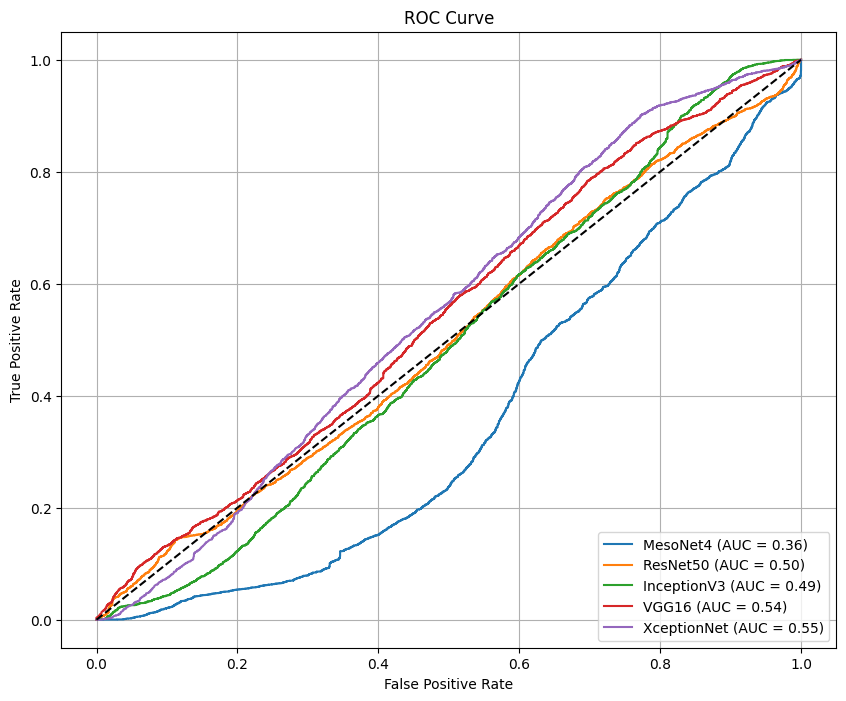

In [154]:

    fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_probs_vgg16)

    fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

    fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

    fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

    fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
    plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50 (AUC = {roc_auc_resnet1:.2f})')
    plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
    plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')
    plt.plot(fpr_xception, tpr_xception, label=f'XceptionNet (AUC = {roc_auc_xception:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:

'''
    fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

    fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

    fpr_resnet2, tpr_resnet2, thresholds_resnet2 = roc_curve(y_true_resnet2, y_pred_probs_resnet2)

    fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

    fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_meso, tpr_meso, label=f'Mesonet4 (AUC = {roc_auc_meso:.2f})')
    plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50_1 (AUC = {roc_auc_resnet1:.2f})')
    plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
    plt.plot(fpr_resnet2, tpr_resnet2, label=f'ResNet50_2 (AUC = {roc_auc_resnet2:.2f})')
    plt.plot(fpr_xception, tpr_xception, label=f'Xception (AUC = {roc_auc_xception:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
'''

In [ ]:
'''
    print("\nОценка ResNet50_2:")
    print("Поддельные изображения:")
    y_true_resnet2, y_pred_probs_resnet2 = evaluate_model(resnet50_model_2, fake_dir, is_resnet=True, num_images=5000, batch_size=128)
    print("Реальные изображения:")
    y_true_resnet2_real, y_pred_probs_resnet2_real = evaluate_model(resnet50_model_2, real_dir, is_resnet=True, num_images=5000, batch_size=128)
    y_true_resnet2.extend(y_true_resnet2_real)
    y_pred_probs_resnet2.extend(y_pred_probs_resnet2_real)

    roc_auc_resnet2 = roc_auc_score(y_true_resnet2, y_pred_probs_resnet2)  # Используем y_pred_probs
    print(f"  ROC AUC: {roc_auc_resnet2:.4f}")
'''